In [1]:
# %tensorflow_version 2.x

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

print(tf.__version__)

2.0.0


In [2]:
train_data_path = "train.csv"
test_data_path = "test.csv"

In [3]:
column_names = ['date','station_code' ,'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff','11~12_takeoff', '18~20_ride']

raw_dataset = pd.read_csv(train_data_path, usecols=column_names,
                          na_values='?', skipinitialspace=True)

train = raw_dataset.copy()

In [4]:
train['date'] = pd.to_datetime(train['date'])
train['date_feature'] = train['date'].dt.weekday
train.loc[train['date_feature'] < 5, 'date_feature'] = 0 # 0 => 평일
train.loc[train['date_feature'] >= 5, 'date_feature'] = 1 # 1 => 주말
train.loc[train['date'] =='2019-09-12 00:00:00', 'date_feature'] = 2
train.loc[train['date'] =='2019-09-13 00:00:00', 'date_feature'] = 2
train.loc[train['date'] =='2019-09-14 00:00:00', 'date_feature'] = 2

test = pd.read_csv(test_data_path)
test['date'] = pd.to_datetime(test['date'])
test['date_feature'] = test['date'].dt.weekday
test.loc[test['date_feature'] < 5, 'date_feature'] = 0 # 0 => 평일
test.loc[test['date_feature'] >= 5, 'date_feature'] = 1 # 1 => 주말
test.loc[test['date'] =='2019-10-03 00:00:00', 'date_feature'] = 2 # 휴일
test.loc[test['date'] =='2019-10-09 00:00:00', 'date_feature'] = 2

In [5]:
train.head()

,date,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,date_feature
0,2019-09-01,시외,344,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2019-09-01,시외,357,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1
2,2019-09-01,시외,432,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1
3,2019-09-01,시내,1579,33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1
4,2019-09-01,시내,1646,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [6]:
train['in_out'] = train['in_out'].map({'시내' : 0, '시외' : 1})
test['in_out'] = test['in_out'].map({'시내' : 0 , '시외' : 1})

In [7]:
!pip install pyresample
import pyresample
import numpy as np

In [8]:
#!pip install pyresample

In [9]:
lon = np.linspace(train['longitude'].min(), train['longitude'].max(), 50)
lat = np.linspace(train['latitude'].min(), train['latitude'].max(), 50)

# 제일 거리가 가까운 grid 인덱스 찾기
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

In [10]:
train['grid_lon'] = train['longitude'].map(lambda x: geo_idx(x, lon))
train['grid_lat'] = train['latitude'].map(lambda x: geo_idx(x, lat))
train.tail()

,date,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,...,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,date_feature,grid_lon,grid_lat
415418,2019-09-30,0,1129,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6,13
415419,2019-09-30,0,1564,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,21,19
415420,2019-09-30,0,2322,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,6,1
415421,2019-09-30,0,3291,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,9,17
415422,2019-09-30,0,6115100,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,21,3


In [11]:
test['grid_lon'] = test['longitude'].map(lambda x: geo_idx(x, lon))
test['grid_lat'] = test['latitude'].map(lambda x: geo_idx(x, lat))

In [12]:
train2 = train.copy()
train2 = pd.get_dummies(train2, columns=['grid_lon', 'grid_lat'])
test = pd.get_dummies(test, columns=['grid_lon', 'grid_lat'])

In [13]:
train2.drop(['latitude', 'longitude'], 1, inplace=True)
test.drop(['latitude', 'longitude'], 1, inplace=True)

In [14]:
train2.drop('date', axis=1, inplace=True)

In [15]:
train2['68a']=train2['6~7_ride']+train2['7~8_ride'] # 6 ~ 8시 승차인원
train2['810a']=train2['8~9_ride']+train2['9~10_ride']
train2['1012a']=train2['10~11_ride']+train2['11~12_ride']

train2['68b']=train2['6~7_takeoff']+train2['7~8_takeoff'] # 6 ~ 8시 하차인원
train2['810b']=train2['8~9_takeoff']+train2['9~10_takeoff']
train2['1012b']=train2['10~11_takeoff']+train2['11~12_takeoff']

In [16]:
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [17]:
train2.drop(['6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff','11~12_takeoff'], axis=1, inplace=True)
test.drop(['6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff','11~12_takeoff'], axis=1, inplace=True)

In [18]:
def seperate_(x):
  if x <=5:
    return 0
  elif x> 5 and x<=10:
    return 1
  else :
    return 2

train2['station_level'] = train2['18~20_ride'].map(seperate_)

In [19]:
sub0 = train2[['station_code','station_level']]
sub1 = test[['station_code']]

In [20]:
sub3 = pd.merge(sub1, sub0, how='left', on='station_code')

In [21]:
sub3.drop('station_code', axis=1, inplace=True)

In [22]:
test['station_level'] = sub3

In [23]:
train2.drop('station_code', axis=1, inplace=True)
test.drop('station_code', axis=1, inplace=True)

In [24]:
test['station_level'] = test['station_level'].fillna(0)

In [25]:
train_dataset = train2.sample(frac=0.8)
val_dataset = train2.drop(train_dataset.index)

train_labels = train_dataset.pop('18~20_ride')
val_labels = val_dataset.pop('18~20_ride')

In [26]:
numeric_columns = ['68a','810a','1012a','68b','810b','1012b']
    

categorical_columns = train_dataset.columns.difference(numeric_columns)
categorical_columns

Index(['date_feature', 'grid_lat_0', 'grid_lat_1', 'grid_lat_10',
       'grid_lat_11', 'grid_lat_12', 'grid_lat_13', 'grid_lat_14',
       'grid_lat_15', 'grid_lat_16', 'grid_lat_17', 'grid_lat_18',
       'grid_lat_19', 'grid_lat_2', 'grid_lat_20', 'grid_lat_21',
       'grid_lat_22', 'grid_lat_23', 'grid_lat_3', 'grid_lat_4', 'grid_lat_47',
       'grid_lat_48', 'grid_lat_49', 'grid_lat_5', 'grid_lat_6', 'grid_lat_7',
       'grid_lat_8', 'grid_lat_9', 'grid_lon_0', 'grid_lon_1', 'grid_lon_10',
       'grid_lon_11', 'grid_lon_12', 'grid_lon_13', 'grid_lon_14',
       'grid_lon_15', 'grid_lon_16', 'grid_lon_17', 'grid_lon_18',
       'grid_lon_19', 'grid_lon_2', 'grid_lon_20', 'grid_lon_21',
       'grid_lon_22', 'grid_lon_23', 'grid_lon_24', 'grid_lon_25',
       'grid_lon_26', 'grid_lon_27', 'grid_lon_28', 'grid_lon_29',
       'grid_lon_3', 'grid_lon_30', 'grid_lon_31', 'grid_lon_32',
       'grid_lon_33', 'grid_lon_34', 'grid_lon_35', 'grid_lon_36',
       'grid_lon_37', 'grid_lo

In [27]:
train_stats = train_dataset.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
68a,332338.0,1.137818,2.873976,0.0,0.0,0.0,1.0,114.0
810a,332338.0,1.456228,3.705659,0.0,0.0,0.0,1.0,181.0
1012a,332338.0,1.178917,3.381330,0.0,0.0,0.0,1.0,174.0
68b,332338.0,0.457570,1.530467,0.0,0.0,0.0,0.0,85.0
810b,332338.0,0.946624,2.671463,0.0,0.0,0.0,1.0,86.0
1012b,332338.0,0.809715,2.501401,0.0,0.0,0.0,1.0,108.0


In [28]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset[numeric_columns])
normed_train_data[categorical_columns] = train_dataset[categorical_columns]
normed_val_data = norm(val_dataset[numeric_columns])
normed_val_data[categorical_columns] = val_dataset[categorical_columns]

In [29]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                5568      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 9,793
Trainable params: 9,793
Non-trainable params: 0
_________________________________________________________________


In [31]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


In [32]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')


.........................................................

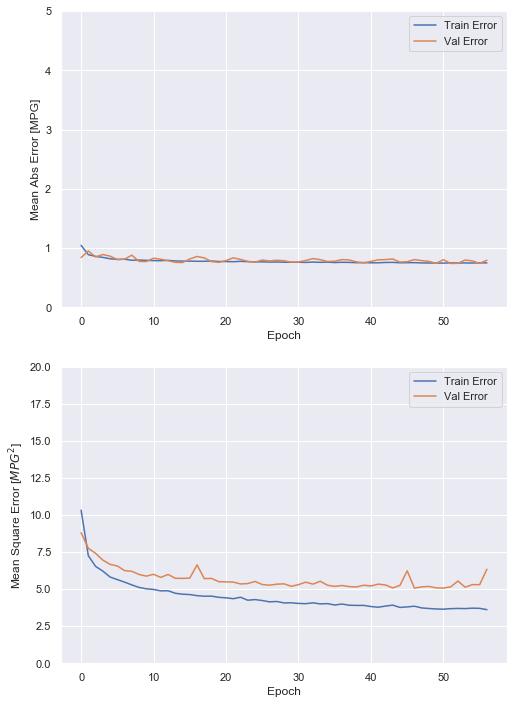

In [33]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [34]:
loss, mae, mse = model.evaluate(normed_val_data, val_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))
print("테스트 세트의 평균 제곱 오차: {:5.2f} MPG".format(mse))

83085/83085 - 4s - loss: 6.1416 - mae: 0.7991 - mse: 6.1416
테스트 세트의 평균 절대 오차:  0.80 MPG
테스트 세트의 평균 제곱 오차:  6.14 MPG


In [35]:
test['grid_lat_47'] = 0

In [36]:
train_labels = train2.pop('18~20_ride')

In [37]:
normed_train_data2 = norm(train2[numeric_columns])
normed_train_data2[categorical_columns] = train2[categorical_columns]
normed_test_data = norm(test[numeric_columns])
normed_test_data[categorical_columns] = test[categorical_columns]


...................

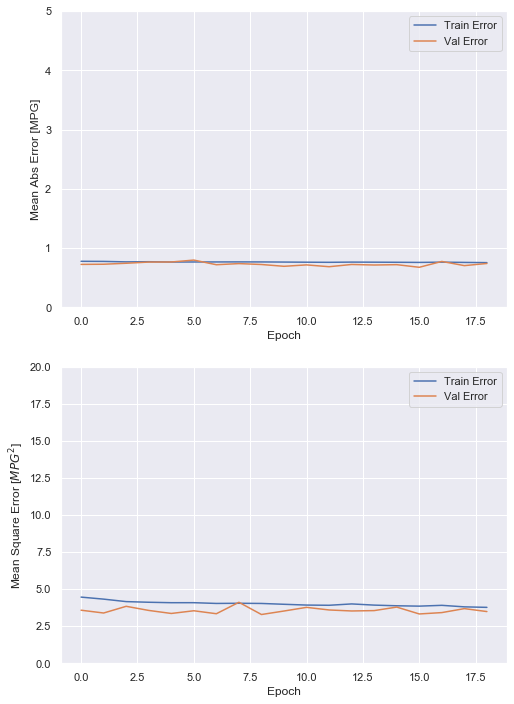

In [38]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000
history = model.fit(normed_train_data2, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [39]:
predictions = model.predict(normed_test_data)

In [40]:
submission_path = "submission_sample.csv"

submission = pd.read_csv(submission_path)
submission['18~20_ride'] = predictions
submission.to_csv("submission.csv", index=False)

2285568/Unknown - 1s 0us/step

In [41]:
submission_path

'C:\\Users\\imdff\\.keras\\datasets\\submission_sample.csv'

In [42]:
import os
os.getcwd()

'C:\\Users\\imdff\\Documents\\Python Scripts\\dacon_winter_school'